In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(["science", "notebook"])

## Data intake

In [4]:
ceda = pd.read_pickle("CEDA_dataNL.pickle")
openmeteo = pd.read_pickle("Data/openmeteo.pickle")
pvgis = pd.read_pickle('Data/PVGIS.pickle')

prod_NL = pd.read_pickle("Data/NL_power.pickle")
meteo2CEDA = {'temperature_2m' :'temperature_1_5m', 
              "relative_humidity_2m":"relative_humidity_1_5m", 
              "pressure_msl": "pressure_MSL",
              "cloud_cover":"total_cloud_amount",
              "shortwave_radiation": "downward_surface_SW_flux",
              "diffuse_radiation":"diffuse_surface_SW_flux",
              "direct_normal_irradiance":"direct_surface_SW_flux",
              "wind_speed_10m": "wind_speed_10m",
              "wind_direction_10m": "wind_direction_10m"
              }
openmeteo = openmeteo.rename(columns=meteo2CEDA)
variates = list(ceda.columns)
rows = int(np.ceil(np.sqrt(len(variates))))

## Historic plot

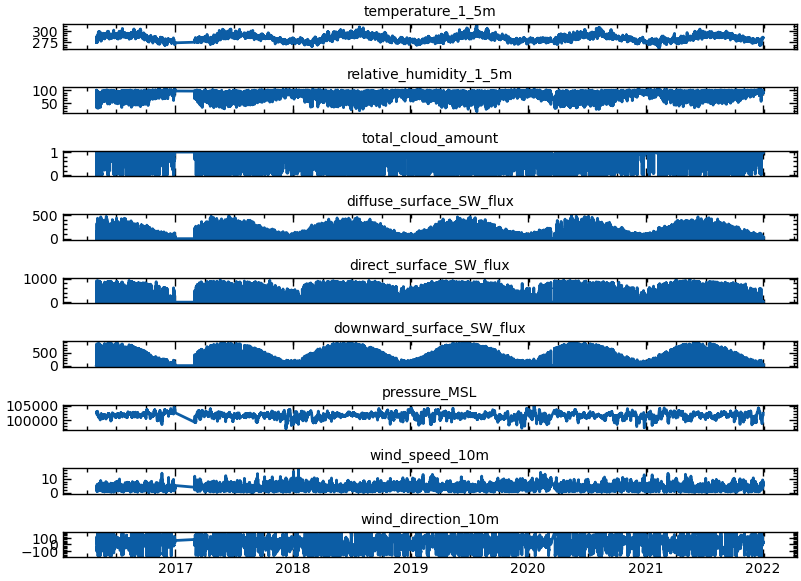

In [5]:
fig, axs = plt.subplots(len(variates), sharex=True)
plt.tight_layout()
for i, var in enumerate(variates):
    axs[i].plot(ceda[var])
    axs[i].set_title(var, fontsize = 10)
    axs[i].tick_params(labelsize=10)
plt.show()


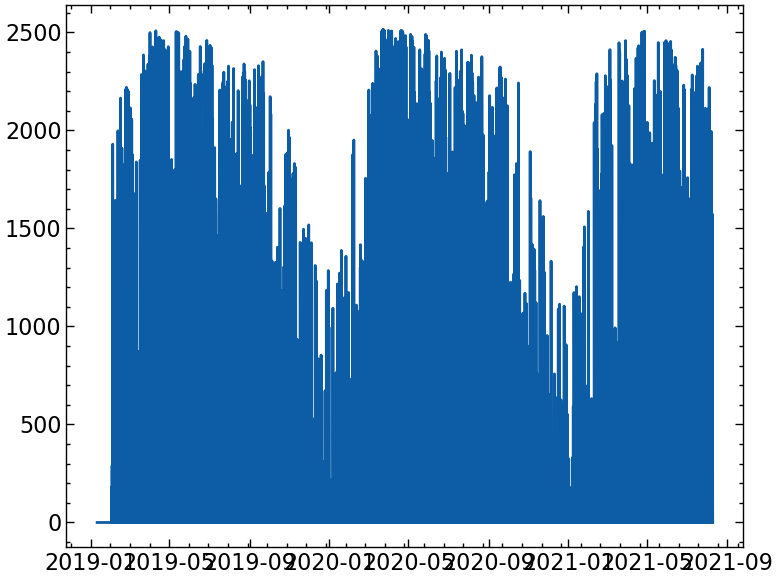

In [6]:
plt.plot(prod_NL)
plt.tight_layout()

## Histograms

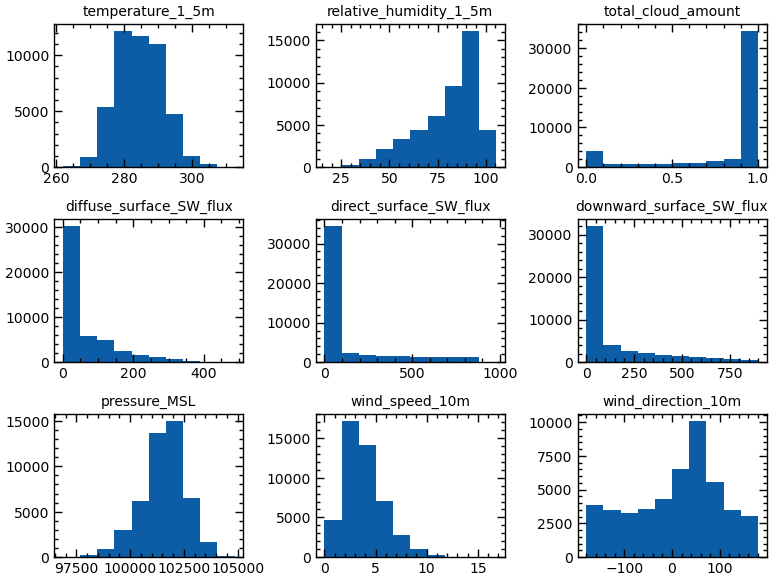

In [7]:
fig, axs = plt.subplots(rows, rows)
plt.tight_layout()
for i, var in enumerate(variates):
    x = i // rows
    y = i % rows
    axs[x,y].hist(ceda[var])
    axs[x,y].set_title(var, fontsize = 10)
    axs[x,y].tick_params(labelsize=10)
plt.show()

## Correlation: CEDA & PROD_NL 

Here add still correlation with transformed variables


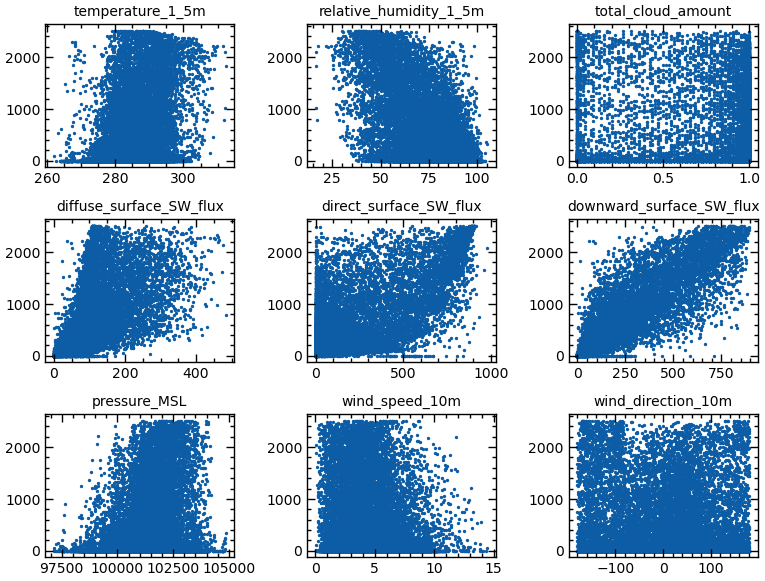

In [8]:
correl = pd.merge(prod_NL, ceda, right_index=True, left_index=True)
fig, axs = plt.subplots(rows, rows)
plt.tight_layout()
for i, var in enumerate(variates):
    x = i // rows
    y = i % rows
    axs[x,y].scatter( correl[var],correl ['P'],s=2)
    axs[x,y].set_title(var, fontsize = 10)
    axs[x,y].tick_params(labelsize=10)
plt.show()

C:\Users\Robbe\AppData\Local\Temp\ipykernel_1996\2427408902.py:6: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


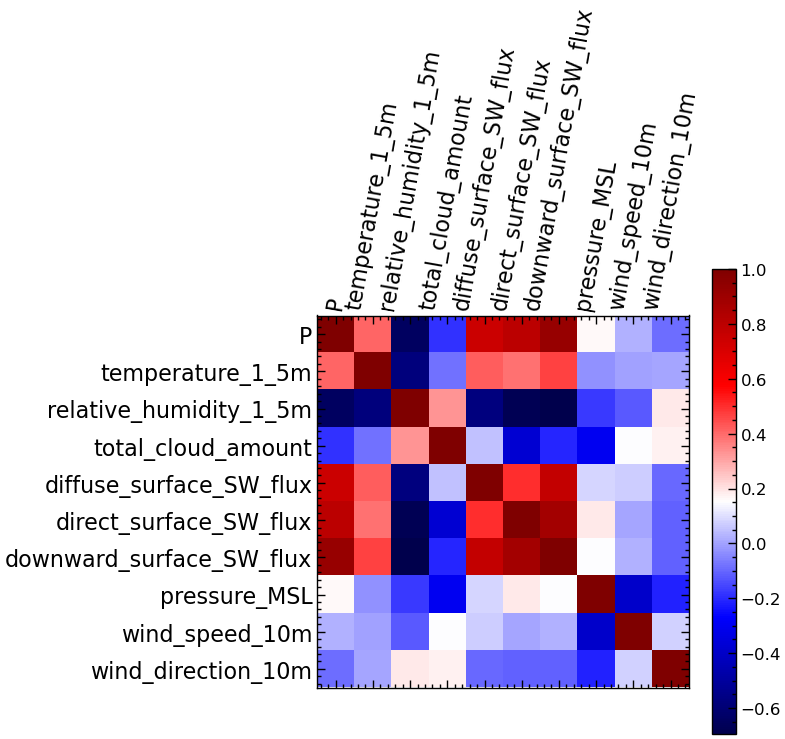

In [9]:
axs = plt.matshow(correl.corr(), cmap='seismic')
plt.xticks(ticks=range(10), labels=list(correl.columns), rotation= 80)
plt.yticks(ticks=range(10), labels = list(correl.columns), rotation= 0)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=12)
plt.tight_layout()
plt.show()

## CEDA VS OPENMETEO

In [10]:
openmeteo = openmeteo.reindex(ceda.index)

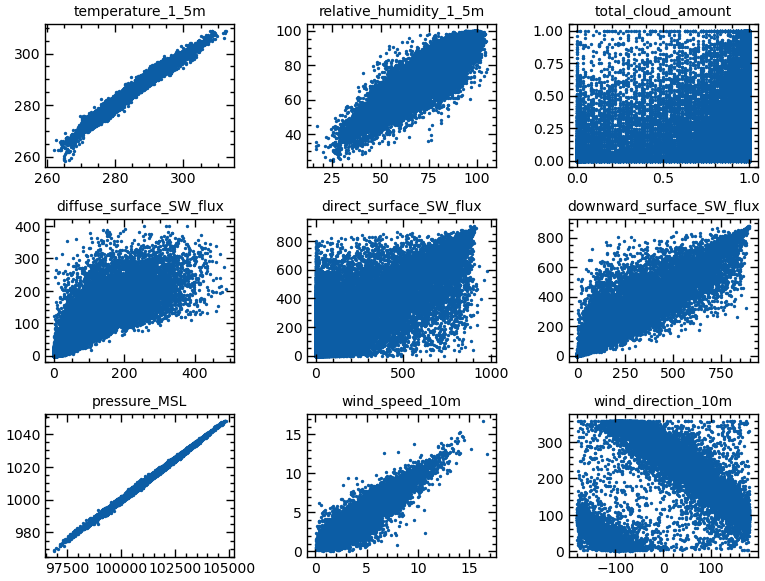

In [11]:
fig, axs = plt.subplots(rows, rows)
plt.tight_layout()
for i, var in enumerate(variates):
    x = i // rows
    y = i % rows
    axs[x,y].scatter(ceda[var], openmeteo[var],s=2)
    axs[x,y].set_title(var, fontsize = 10)
    axs[x,y].tick_params(labelsize=10)
plt.show()

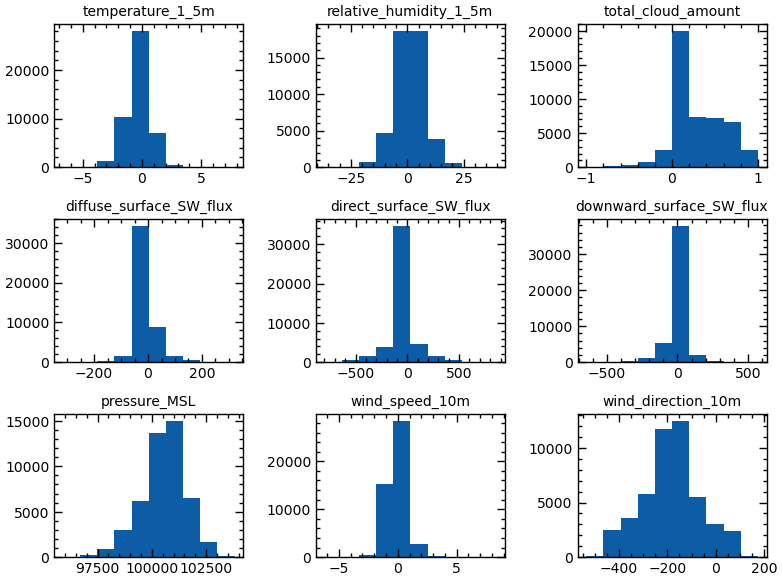

In [12]:
fig, axs = plt.subplots(rows, rows)
plt.tight_layout()
for i, var in enumerate(variates):
    x = i // rows
    y = i % rows
    axs[x,y].hist(ceda[var]-openmeteo[var])
    axs[x,y].set_title(var, fontsize = 10)
    axs[x,y].tick_params(labelsize=10)
plt.show()

## PROD_NL VS PVGIS

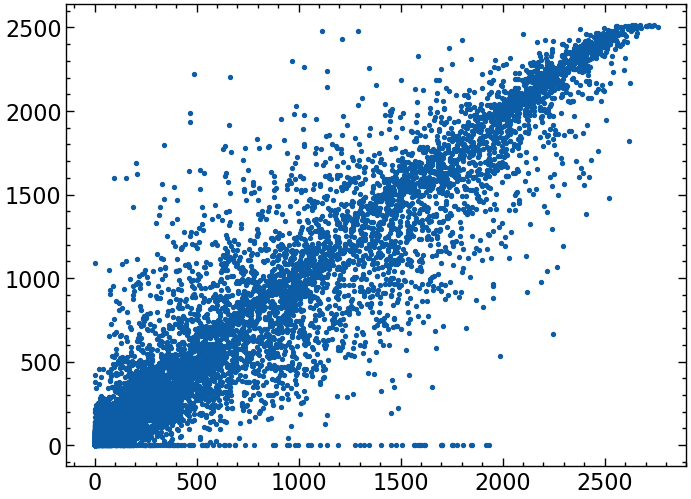

In [13]:
powers= pd.merge(pvgis, prod_NL, left_index=True, right_index=True)
plt.scatter(powers['P_x'], powers['P_y'], s=8)

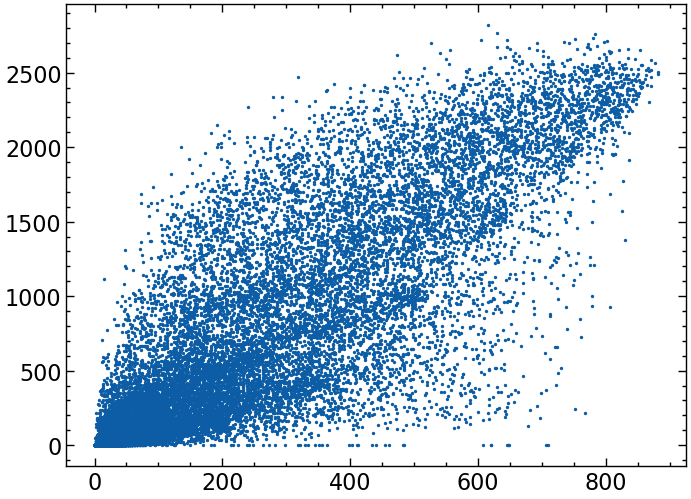

In [19]:
debug = pd.merge(openmeteo, pvgis, left_index=True, right_index=True)
plt.scatter(debug['downward_surface_SW_flux'], debug['P'], s=2)

## Check for nighttime PV power

In [37]:
is_day = pd.read_pickle("is_day.pickle")
daytime = pd.merge(is_day, debug[["P", "downward_surface_SW_flux"]], left_index=True, right_index=True)


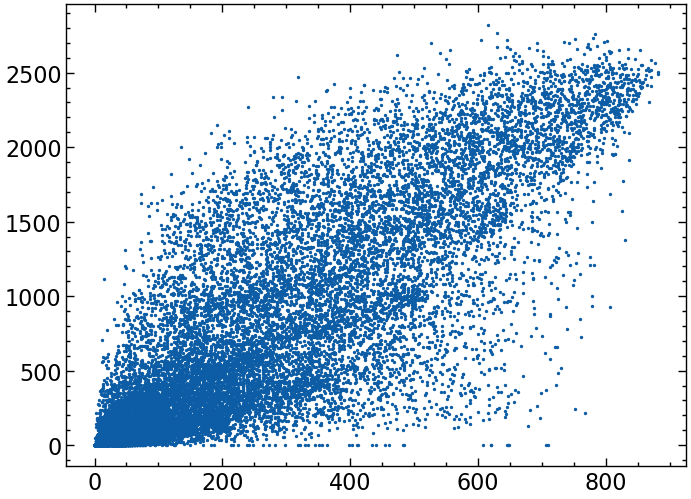

In [39]:
daytime = daytime[daytime['is_day']]
plt.scatter(daytime['downward_surface_SW_flux'], daytime['P'], s=2)